# Implements Fluid Propagation 
Lets make sure we're getting the fluid propagation correct first

In [1]:
# imports
import numpy as np 
import matplotlib.pyplot as plt
import sys
from math import sin, cos, pi, tanh
from random import seed
from numpy.random import random
from numpy import exp

In [297]:
from utils_2D import convolve_matrix, w_matrix 

#eps = 0.3; res = 20 # eps gives communication length, res is resolution
eps =0.1; res=50
dim = int(np.ceil(res*(1+2*eps))) # expand range to get good communication length

V=1 # set v order 1
dt = 1/2*(1/res)*V/2/2/10 # dt based on the CFL condition  - PLAY


phi_rand = random((dim, dim))

# apply smoothing
smoothed = convolve_matrix(phi_rand, eps, res)/2

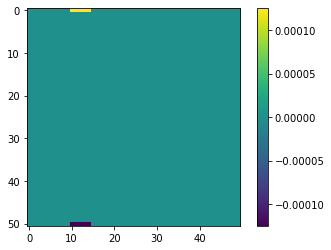

In [311]:
# initilize rho0 to have pressure 1

# from utils_2D import Kappa
# new kappa definition
def Kappa(p):
    return 1/(p**2/(1-p)**3)

def pressure(rho, c=1): # PLAY with c
    return c*(rho-1)
rho0 = np.ones((res,res))
def flux_x(rho, phi, BC=np.zeros((rho0.shape[0],rho0.shape[1]+1)), dx =1/res, dt =dt):
    x_flux = np.zeros((rho0.shape[0],rho0.shape[1]+1))
    for row in range(x_flux.shape[0]):
        for column in range(1, x_flux.shape[1]-1):
            T1 = (rho[row, column-1]+rho[row, column])/2
            T2 = Kappa((phi[row, column-1]+phi[row, column])/2)
            T3 = (pressure(rho[row, column-1])-pressure(rho[row, column]))/dx
            x_flux[row, column] = T1*T2*T3
    return x_flux+dt*BC

def flux_y(rho, phi, BC=np.zeros((rho0.shape[0]+1,rho0.shape[1])), dy =1/res, dt=dt):
    y_flux = np.zeros((rho0.shape[0]+1,rho0.shape[1]))
    for row in range(1, y_flux.shape[0]-1):
        for column in range(y_flux.shape[1]):
            T1 = (rho[row-1, column]+rho[row, column])/2
            T2 = Kappa((phi[row-1, column]+phi[row, column])/2)
            T3 = (pressure(rho[row-1, column])-pressure(rho[row, column]))/dy
            y_flux[row, column] = T1*T2*T3
    return y_flux + dt*BC
BC_y = np.zeros((rho0.shape[0]+1,rho0.shape[1]))
BC_y[0, 10:15] = np.ones(5)/2
BC_y[-1, 10:15] = -np.ones(5)/2
plt.imshow(flux_y(rho0, smoothed, BC_y))
plt.colorbar()

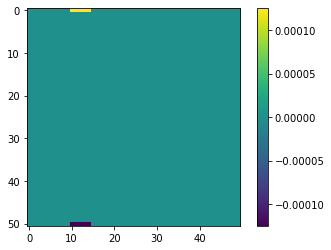

In [312]:
def update_rho(rho, phi, BC_x, BC_y, dt=dt, dx =1/res, dy = 1/res):
    # calculate mass flux at each boundary
    fx = flux_x(rho, phi, BC_x, dx=dx, dt=dt)
    fy = flux_y(rho, phi, BC_y, dy=dy, dt=dt)
    # initialize a flux matrix to get mass flux into a cell - this gives us an update for rho 
    flux_mat = np.zeros(rho.shape)
    for row in range(flux_mat.shape[0]):
        for column in range(flux_mat.shape[1]):
            fmat_x = (fx[row, column+1]-fx[row, column])/dx # flux in x-direction 
            fmat_y = (fy[row, column] - fy[row+1, column])/dy # flux in y-direction
            flux_mat[row, column] = -(fmat_x+fmat_y) # flux INTO the cell 
    return flux_mat, fx, fy
BCx_empty = np.zeros((rho0.shape[0], rho0.shape[1]+1))
plt.imshow(update_rho(rho0, smoothed, BCx_empty, BC_y)[2])
plt.colorbar()


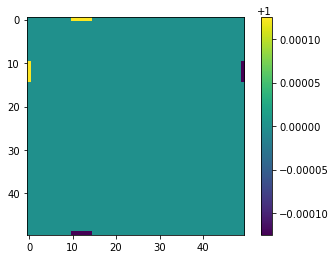

In [313]:
def update_rho(rho, phi, BC_x, BC_y, dt=dt, dx =1/res, dy = 1/res):
    # calculate mass flux at each boundary
    fx = flux_x(rho, phi, BC_x, dx=dx, dt=dt)
    fy = flux_y(rho, phi, BC_y, dy=dy, dt=dt)
    # initialize a flux matrix to get mass flux into a cell - this gives us an update for rho 
    flux_mat = np.zeros(rho.shape)
    for row in range(flux_mat.shape[0]):
        for column in range(flux_mat.shape[1]):
            # if any([fx[row, column+1],fx[row, column],fy[row, column],fy[row+1, column]]) !=0:
            #     print(row, column, [fx[row, column+1],fx[row, column],fy[row, column],fy[row+1, column]])

            #fmat_x = (fx[row, column+1]-fx[row, column]) # flux in x-direction 
            #fmat_y = (fy[row, column] - fy[row+1, column]) # flux in y-direction # Not mathematically correct but works physically
            fmat_x = (fx[row, column+1]+fx[row, column]) # flux in x-direction 
            fmat_y = (fy[row, column] + fy[row+1, column]) # flux in y-direction # Not mathematically correct but works physically
            
            flux_mat[row, column] = (fmat_x+fmat_y)
            # if val !=0:
            #     print(row, column, val)
            #flux_mat[row, column] = -(fmat_x+fmat_y) # flux INTO the cell 
    return rho+flux_mat, fx, fy
BC_x = np.zeros((rho0.shape[0], rho0.shape[1]+1))
BC_x[10:15, 0] = np.ones(5)/2
BC_x[10:15, -1] = -np.ones(5)/2
plt.imshow(update_rho(rho0, smoothed, BC_x, BC_y)[0])
plt.colorbar()

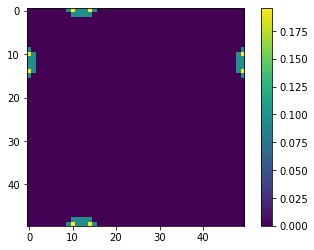

In [308]:
def calc_pressure(rho_new, dx =1/res, dy=1/res):
    """Second order central difference gives the pressure"""
    # dx_mat = np.zeros(rho_new.shape)
    # dy_mat = np.zeros(rho_new.shape)
    p_mat = np.zeros(rho_new.shape)
    for row in range(rho_new.shape[0]):
        for column in range(rho_new.shape[1]):
            px = 0; py =0
            if column ==0: # forwards central difference
                px = (rho_new[row, column+2]-2*rho_new[row, column+1]+rho_new[row, column])/(dx**2)
            elif column == rho_new.shape[1]-1: # backwards
                px = (rho_new[row, column]-2*rho_new[row, column-1]+rho_new[row, column-2])/(dx**2)
            else: # centered 
                px = (rho_new[row, column+1]-2*rho_new[row, column]+rho_new[row, column-1])/(dx**2)
            if row ==0: # forwards central diff
                py = (rho_new[row+2, column]-2*rho_new[row+1, column]+rho_new[row, column])/(dy**2)
            elif row ==rho_new.shape[0]-1: # backwards
                py = (rho_new[row, column]-2*rho_new[row-1, column]+rho_new[row-2, column])/(dy**2)
            else:  # calculate second order centered difference
                py = (rho_new[row+1, column]-2*rho_new[row, column]+rho_new[row-1, column])/(dy**2)
            # calculate squared gradient of pressure 
            p_mat[row, column] = px**2+py**2
    return p_mat

plt.imshow(calc_pressure(update_rho(rho0, smoothed, BC_x, BC_y)[0]))
plt.colorbar()

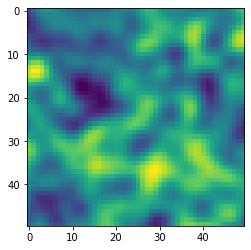

In [309]:
# update phi based on changes to rho
def psi(phi, c1 =0.5, w=5, phistar=0.4, c2=0.5): # change stuff in HERE 
    return c1*tanh(w*(phi-phistar))+c2

def update_phi(phi, pressure, dt=dt, c=500):
    # get a derivative for phi
    dphi_dt = np.zeros(phi.shape)
    for i in range(dphi_dt.shape[0]):
        for j in range(dphi_dt.shape[1]):
            # based off pressure and function of solid fraction; always <=0
            dphi_dt[i,j] = - phi[i,j] * np.max([0, pressure[i,j]/c-psi(phi[i,j])]) # PLAY with dividing pressure
    # use forward Euler to update
    phi_next = phi + dt * dphi_dt
    # we can't have a negative solid fraction - we set this to zero
    phi_next = np.maximum(phi_next, np.zeros(phi_next.shape))
    return phi_next

new_phi = update_phi(smoothed, calc_pressure(update_rho(rho0, smoothed, BC_x, BC_y)[0]), dt=dt, c=1)

plt.imshow(new_phi)

CPU times: user 569 ms, sys: 31.5 ms, total: 600 ms
Wall time: 583 ms


<ipython-input-308-094a658437d8>:22: RuntimeWarning: overflow encountered in double_scalars
  p_mat[row, column] = px**2+py**2
<ipython-input-309-31b6266d2191>:11: RuntimeWarning: invalid value encountered in double_scalars
  dphi_dt[i,j] = - phi[i,j] * np.max([0, pressure[i,j]/c-psi(phi[i,j])]) # PLAY with dividing pressure
<ipython-input-308-094a658437d8>:14: RuntimeWarning: overflow encountered in double_scalars
  px = (rho_new[row, column+1]-2*rho_new[row, column]+rho_new[row, column-1])/(dx**2)
<ipython-input-308-094a658437d8>:16: RuntimeWarning: overflow encountered in double_scalars
  py = (rho_new[row+2, column]-2*rho_new[row+1, column]+rho_new[row, column])/(dy**2)
<ipython-input-308-094a658437d8>:20: RuntimeWarning: overflow encountered in double_scalars
  py = (rho_new[row+1, column]-2*rho_new[row, column]+rho_new[row-1, column])/(dy**2)


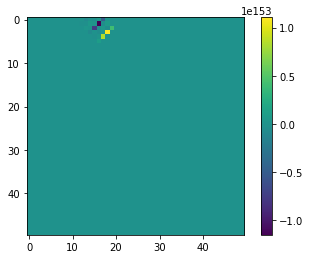

In [315]:
%%time
phi_list = [smoothed]; rho_list =[rho0]
for i in range(10):
    rho_next = update_rho(rho_list[i], smoothed, BC_x, BC_y)[0]
    pressure_current = calc_pressure(rho_next)
    phi_new = update_phi(phi_list[i], pressure_current, dt=dt, c=1)
    phi_list.append(phi_new); rho_list.append(rho_next)
plt.imshow(rho_list[9])
plt.colorbar()

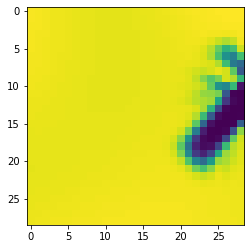

In [279]:
plt.imshow(phi_list[-1][1:30, -30:-1])

In [220]:
# boundary conditions
BC_y = np.zeros((rho0.shape[0]+1,rho0.shape[1]))
BC_y[0, 10:15] = np.ones(5)/2
BC_y[-1, 10:15] = -np.ones(5)/2

BC_x = np.zeros((rho0.shape[0], rho0.shape[1]+1))
BC_x[10:15, 0] = np.ones(5)/2
BC_x[10:15, -1] = -np.ones(5)/2

# update rho
def time_step(phi, rho, BC_x, BC_y):
    # update rho
    rho_next = update_rho(rho0, smoothed, BC_x, BC_y)[2]
    # get pressure from rho
    pressure = calc_pressure(rho_next)
    # update phi 
    phi_next = update_phi(phi, pressure, dt=dt)
    return phi_next, rho_next, pressure
phis = [smoothed]; rhos = [rho0]
for i in range(100):
    phi, rho, press = time_step(phis[i], rhos[i], BC_x, BC_y)
    phis.append(phi)
    rhos.append(rho)

# plt.imshow(time_step(smoothed, rho0, BC_x, BC_y)[0])
# plt.colorbar()



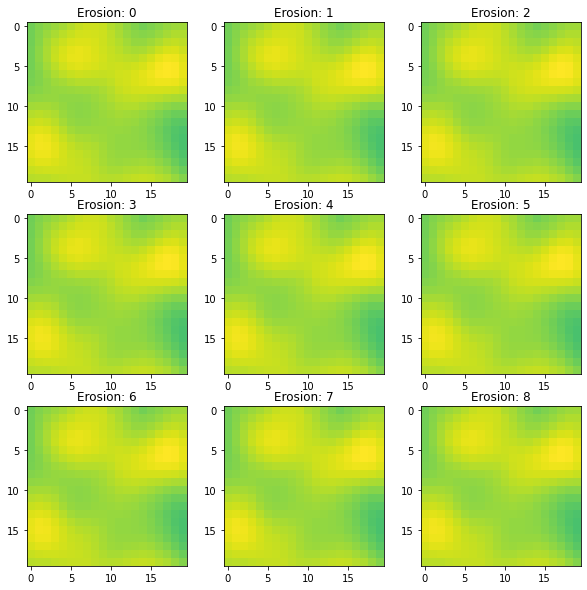

In [127]:
fig, ax = plt.subplots(3,3, figsize=((10,10)))

axs = ax.ravel()

for i in range(9):
    axs[i].imshow(phis[i+80], vmin=0, vmax = 1)
    axs[i].set_title(f"Erosion: {i}")